In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from utilidades.validar import validar
from utilidades.reducir_uso_memoria import reduce_mem_usage
from utilidades.dolarizar import dolarizar
from utilidades.dolarizar import desdolarizar
from utilidades.dolarizar import agregar_dolar_como_feature
from utilidades.generar_submit import generar_submit
from utilidades.subir_submit import subir

from xgboost import XGBRegressor

## Prueba base para XGBoost, solo habiendo rellenado NaNs y habiendo encodeado las variables categoricas

In [2]:
train = pd.read_csv("data/train_limpio.csv")
test = pd.read_csv("data/test_limpio.csv")

In [3]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

In [4]:
X, y = train.drop(["precio"], axis=1),train["precio"]

In [5]:
validar(X,y, XGBRegressor, True, objective ='reg:squarederror')

/home/julian/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Error de fold N°0 es : 772963.3480403646


/home/julian/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Error de fold N°1 es : 767042.6739726563


/home/julian/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Error de fold N°2 es : 775716.3376842448


/home/julian/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Error de fold N°3 es : 767077.0683235677


/home/julian/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Error de fold N°4 es : 764521.6817584635


### Graficamos las predicciones contra los valores reales:

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [7]:
reg = XGBRegressor()
y_train = np.log(y_train)
reg.fit(X_train, y_train)
pred = reg.predict(X_test)
pred = np.exp(pred)

/home/julian/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:43:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [8]:
mean_absolute_error(y_test, pred)

769642.0117530776

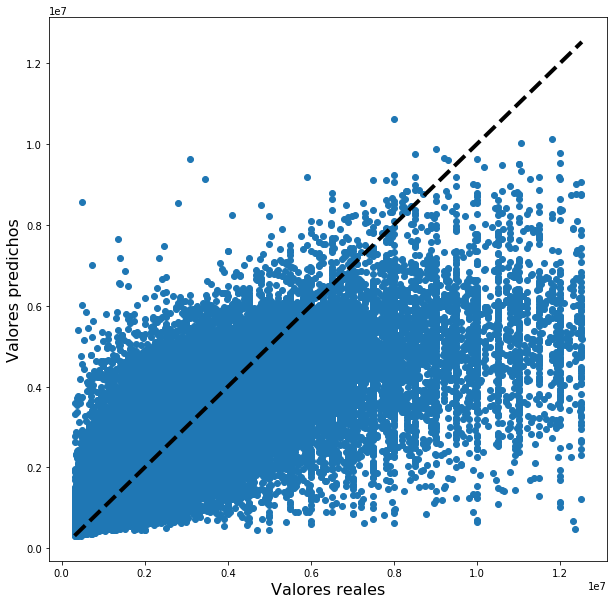

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(y_test, pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel("Valores reales", fontsize=16)
ax.set_ylabel("Valores predichos", fontsize=16);

### Se puede ver que el modelo es bastante conservador en el sentido de que casi nunca predice valores muy altos, por lo que se observa un alejamiento respecto la diagonal ideal a medida que los precios reales aumentan

## Se prueba dolarizar los precios para entrenar

In [10]:
train = pd.read_csv("data/train_limpio.csv")
test = pd.read_csv("data/test_limpio.csv")

In [11]:
train = dolarizar(train)

In [12]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

In [13]:
X, y = train.drop(["precio"], axis=1),train["precio"]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [15]:
reg = XGBRegressor()
y_train = np.log(y_train)
reg.fit(X_train, y_train)
pred = reg.predict(X_test)
pred = np.exp(pred)

/home/julian/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:44:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [16]:
pred = desdolarizar(X_test, pred)

/home/julian/Documentos/Datos/c2/TPs-Org.Datos/tp2/utilidades/dolarizar.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["precio"] = y
/home/julian/Documentos/Datos/c2/TPs-Org.Datos/tp2/utilidades/dolarizar.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["precio"] = df.apply(lambda x: x["precio"]*valor_dolar[(x["anio"], x["mes"], x["dia"])], axis=1)


####  TODO: Revisar este error, puede ser que no se esten modificando bien las cosas y por eso la falta de difierencia

In [17]:
y_test = desdolarizar(X_test, y_test)

## Como se puede ver se obtienen resultados casi similares que sin dolarizar los precios

In [18]:
mean_absolute_error(y_test, pred)

769520.8975217558

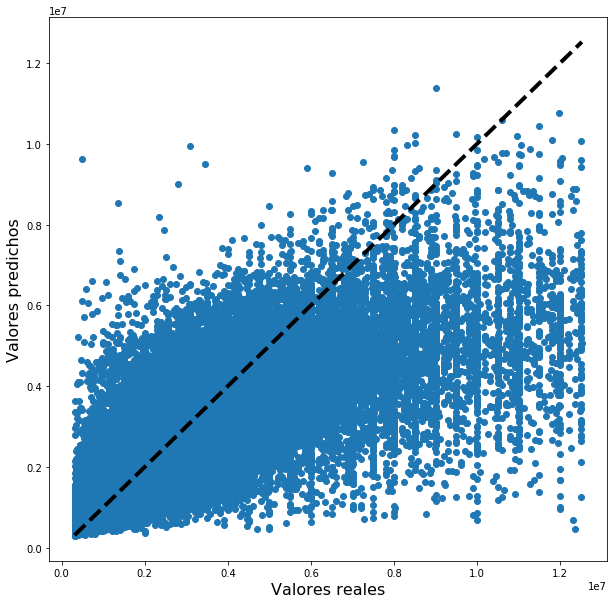

In [19]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(y_test, pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel("Valores reales", fontsize=16)
ax.set_ylabel("Valores predichos", fontsize=16);

## Probamos en cambio agregar la cotizacion del dolar para ese dia como un feature:

In [20]:
train = pd.read_csv("data/train_limpio.csv")
test = pd.read_csv("data/test_limpio.csv")

In [21]:
train_d = agregar_dolar_como_feature(train)
test_d = agregar_dolar_como_feature(test)

In [22]:
train_d = reduce_mem_usage(train_d)
test_d = reduce_mem_usage(test_d)

In [23]:
X, y = train_d.drop(["precio"], axis=1),train_d["precio"]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [25]:
reg = XGBRegressor(objective ='reg:squarederror')
y_train = np.log(y_train)
reg.fit(X_train, y_train)
pred = reg.predict(X_test)
pred = np.exp(pred)

/home/julian/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [26]:
mean_absolute_error(y_test, pred)

770186.3329592803

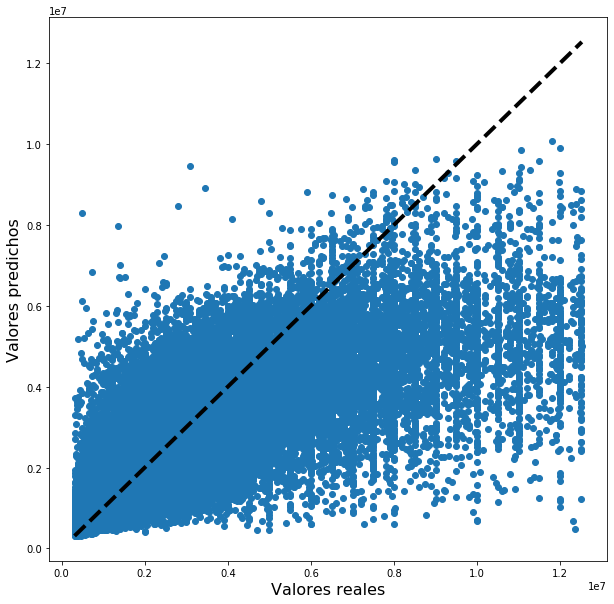

In [27]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(y_test, pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel("Valores reales", fontsize=16)
ax.set_ylabel("Valores predichos", fontsize=16);

## Veamos que pasa aplicando log a los metros cuadrados y tuneando un poco:

In [28]:
train = pd.read_csv("data/train_limpio.csv")
test = pd.read_csv("data/test_limpio.csv")

In [29]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

In [30]:
train["metroscubiertos"] = np.log(train["metroscubiertos"])
train["metrostotales"] = np.log(train["metrostotales"])

test["metroscubiertos"] = np.log(test["metroscubiertos"])
test["metrostotales"] = np.log(test["metrostotales"])

In [31]:
X, y = train.drop(["precio"], axis=1),train["precio"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [32]:
reg = XGBRegressor(max_depth=15, min_child_weight=0.01)
y_train = np.log(y_train)
reg.fit(X_train, y_train)
pred = reg.predict(X_test)
pred = np.exp(pred)

/home/julian/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:45:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [33]:
mean_absolute_error(y_test, pred)

661391.7408045296

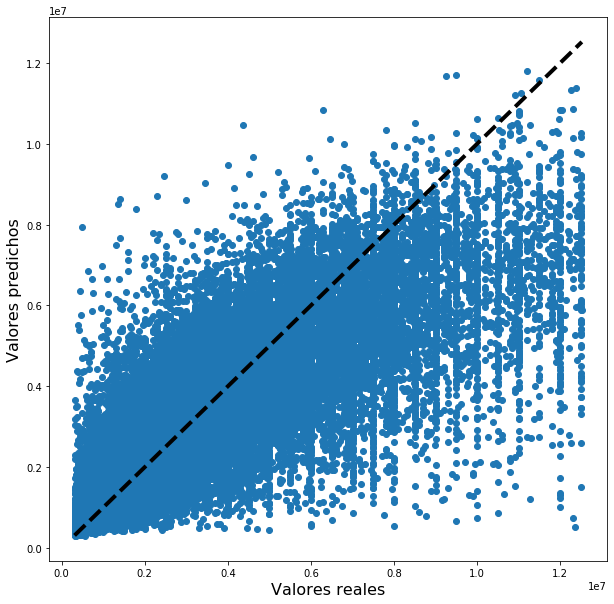

In [34]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(y_test, pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel("Valores reales", fontsize=16)
ax.set_ylabel("Valores predichos", fontsize=16);

### Cambiar los parametros aunque sea medio a ojo mejoro muchisimo los resultados, aproximadamente 100k de mejora

---

## Agregamos la poblacion de cada ciudad como feature y probamos algunos valores distintos para XGBoost

In [35]:
train = pd.read_csv("data/train_limpio.csv")
test = pd.read_csv("data/test_limpio.csv")

In [36]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

In [37]:
train_origi = pd.read_csv("data/train.csv")

poblaciones = pd.read_csv("data/poblacion_de_cada_ciudad.csv")

d_poblaciones = poblaciones.set_index("ciudad")["poblacion"].to_dict()

train_origi["ciudad"].fillna(train_origi['ciudad'].mode()[0], inplace=True)

train_origi["pob_ciu"] = train_origi.apply(lambda x: d_poblaciones[x["ciudad"]], axis=1)

train["pob_ciu"] = train_origi["pob_ciu"]

In [38]:
X, y = train.drop(["precio"], axis=1),train["precio"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [39]:
reg = XGBRegressor(max_depth=15, min_child_weight=0.01)
y_train = np.log(y_train)
reg.fit(X_train, y_train)
pred = reg.predict(X_test)
pred = np.exp(pred)

/home/julian/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:48:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [40]:
mean_absolute_error(y_test, pred)

598457.7419397096

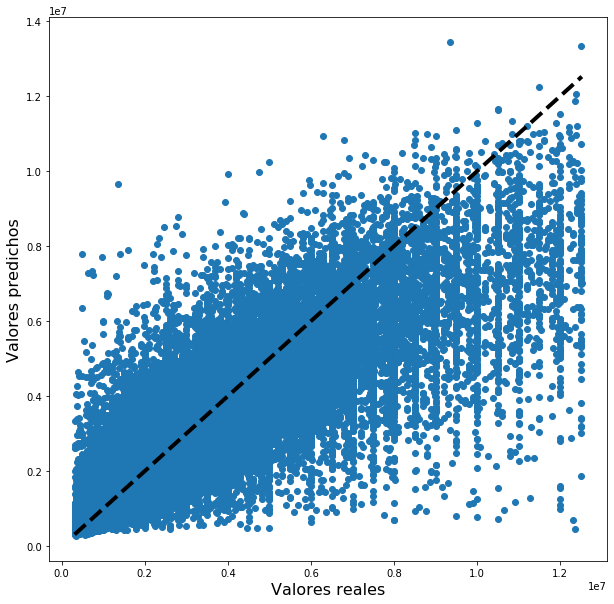

In [41]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(y_test, pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel("Valores reales", fontsize=16)
ax.set_ylabel("Valores predichos", fontsize=16);

## Nuevamente obtenemos un gran cambio, se obtiene una mejora de 60k logrando bajar de los 600k 